# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:17, 10.2MB/s]                           
SVHN Testing Set: 64.3MB [00:08, 7.64MB/s]                            


These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

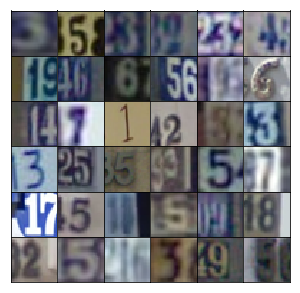

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha*x, x)
        # 4 * 4 * 512 now.
        
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        
        
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've built before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [17]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5


# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/25... Discriminator Loss: 0.9964... Generator Loss: 1.0634
Epoch 1/25... Discriminator Loss: 0.3254... Generator Loss: 2.8675
Epoch 1/25... Discriminator Loss: 0.1644... Generator Loss: 2.6291
Epoch 1/25... Discriminator Loss: 0.1420... Generator Loss: 3.0140
Epoch 1/25... Discriminator Loss: 0.1889... Generator Loss: 2.5887
Epoch 1/25... Discriminator Loss: 0.1039... Generator Loss: 2.9510
Epoch 1/25... Discriminator Loss: 0.1791... Generator Loss: 2.4985
Epoch 1/25... Discriminator Loss: 0.1232... Generator Loss: 3.2583
Epoch 1/25... Discriminator Loss: 0.2120... Generator Loss: 2.4550
Epoch 1/25... Discriminator Loss: 1.1622... Generator Loss: 3.7912


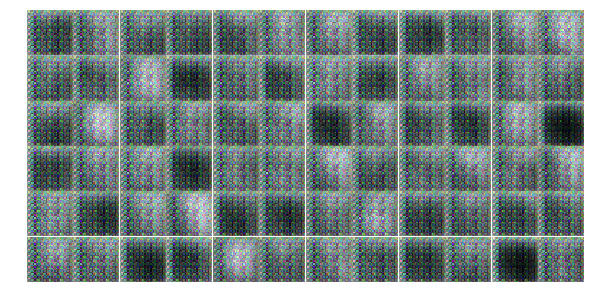

Epoch 1/25... Discriminator Loss: 0.5939... Generator Loss: 1.8176
Epoch 1/25... Discriminator Loss: 0.3822... Generator Loss: 2.6394
Epoch 1/25... Discriminator Loss: 0.7428... Generator Loss: 1.1309
Epoch 1/25... Discriminator Loss: 0.4561... Generator Loss: 2.2728
Epoch 1/25... Discriminator Loss: 0.4420... Generator Loss: 1.8265
Epoch 1/25... Discriminator Loss: 0.5564... Generator Loss: 1.9257
Epoch 1/25... Discriminator Loss: 0.3813... Generator Loss: 2.1741
Epoch 1/25... Discriminator Loss: 0.2670... Generator Loss: 2.3454
Epoch 1/25... Discriminator Loss: 0.4995... Generator Loss: 3.2825
Epoch 1/25... Discriminator Loss: 0.0962... Generator Loss: 2.8460


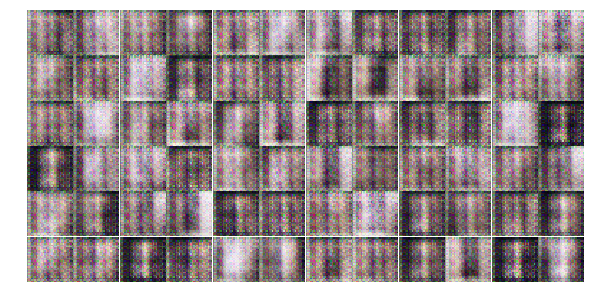

Epoch 1/25... Discriminator Loss: 1.5665... Generator Loss: 1.2713
Epoch 1/25... Discriminator Loss: 0.1322... Generator Loss: 3.4425
Epoch 1/25... Discriminator Loss: 0.9032... Generator Loss: 2.8975
Epoch 1/25... Discriminator Loss: 0.7441... Generator Loss: 2.6513
Epoch 1/25... Discriminator Loss: 0.3967... Generator Loss: 2.2036
Epoch 1/25... Discriminator Loss: 0.2829... Generator Loss: 2.2905
Epoch 1/25... Discriminator Loss: 0.6571... Generator Loss: 1.4205
Epoch 1/25... Discriminator Loss: 0.5528... Generator Loss: 1.8633
Epoch 1/25... Discriminator Loss: 0.9054... Generator Loss: 0.9117
Epoch 1/25... Discriminator Loss: 0.7895... Generator Loss: 1.2255


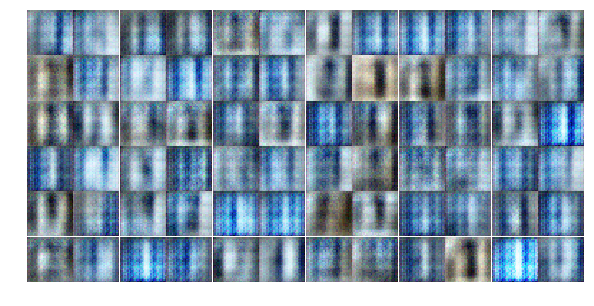

Epoch 1/25... Discriminator Loss: 0.8132... Generator Loss: 1.3971
Epoch 1/25... Discriminator Loss: 0.6079... Generator Loss: 1.3961
Epoch 1/25... Discriminator Loss: 0.9602... Generator Loss: 1.1400
Epoch 1/25... Discriminator Loss: 1.0344... Generator Loss: 0.8607
Epoch 1/25... Discriminator Loss: 0.6983... Generator Loss: 1.6048
Epoch 1/25... Discriminator Loss: 0.8288... Generator Loss: 1.3058
Epoch 1/25... Discriminator Loss: 0.6832... Generator Loss: 1.0858
Epoch 1/25... Discriminator Loss: 0.4081... Generator Loss: 2.3387
Epoch 1/25... Discriminator Loss: 0.4949... Generator Loss: 1.9734
Epoch 1/25... Discriminator Loss: 0.4768... Generator Loss: 1.8515


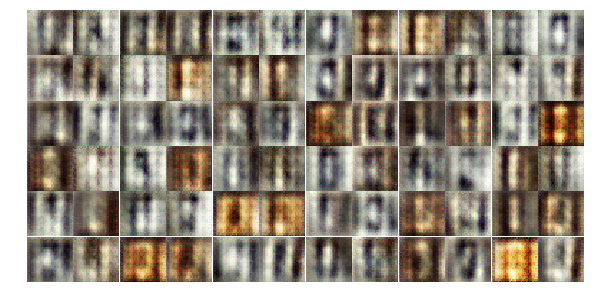

Epoch 1/25... Discriminator Loss: 0.7116... Generator Loss: 2.3262
Epoch 1/25... Discriminator Loss: 0.5274... Generator Loss: 1.6529
Epoch 1/25... Discriminator Loss: 0.8194... Generator Loss: 0.9446
Epoch 1/25... Discriminator Loss: 0.5725... Generator Loss: 1.4377
Epoch 1/25... Discriminator Loss: 0.3767... Generator Loss: 1.9809
Epoch 1/25... Discriminator Loss: 0.5283... Generator Loss: 1.7636
Epoch 1/25... Discriminator Loss: 0.5872... Generator Loss: 2.3337
Epoch 1/25... Discriminator Loss: 0.7884... Generator Loss: 1.5906
Epoch 1/25... Discriminator Loss: 0.7990... Generator Loss: 1.1810
Epoch 1/25... Discriminator Loss: 0.7142... Generator Loss: 1.4122


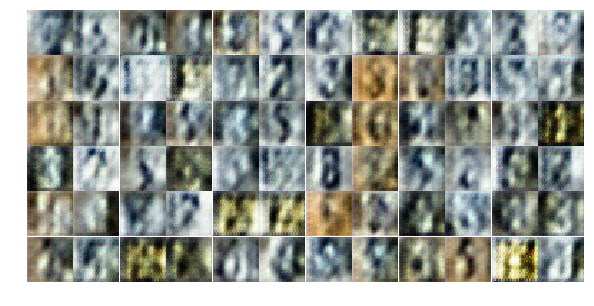

Epoch 1/25... Discriminator Loss: 0.6116... Generator Loss: 1.3962
Epoch 1/25... Discriminator Loss: 1.1622... Generator Loss: 0.5846
Epoch 1/25... Discriminator Loss: 0.6268... Generator Loss: 1.6818
Epoch 1/25... Discriminator Loss: 0.9076... Generator Loss: 0.9492
Epoch 1/25... Discriminator Loss: 0.5604... Generator Loss: 1.8436
Epoch 1/25... Discriminator Loss: 0.5306... Generator Loss: 1.4453
Epoch 1/25... Discriminator Loss: 0.7358... Generator Loss: 1.0667
Epoch 2/25... Discriminator Loss: 0.6608... Generator Loss: 1.6696
Epoch 2/25... Discriminator Loss: 0.8386... Generator Loss: 2.3810
Epoch 2/25... Discriminator Loss: 0.5633... Generator Loss: 1.5351


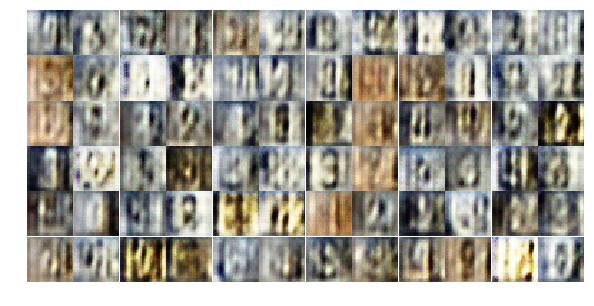

Epoch 2/25... Discriminator Loss: 0.8285... Generator Loss: 0.9841
Epoch 2/25... Discriminator Loss: 0.8896... Generator Loss: 1.0085
Epoch 2/25... Discriminator Loss: 1.1046... Generator Loss: 0.9814
Epoch 2/25... Discriminator Loss: 0.9890... Generator Loss: 0.8550
Epoch 2/25... Discriminator Loss: 1.0382... Generator Loss: 1.0569
Epoch 2/25... Discriminator Loss: 1.0161... Generator Loss: 0.9930
Epoch 2/25... Discriminator Loss: 0.9399... Generator Loss: 1.2340
Epoch 2/25... Discriminator Loss: 1.4080... Generator Loss: 0.6598
Epoch 2/25... Discriminator Loss: 1.2962... Generator Loss: 0.7094
Epoch 2/25... Discriminator Loss: 0.9015... Generator Loss: 1.2013


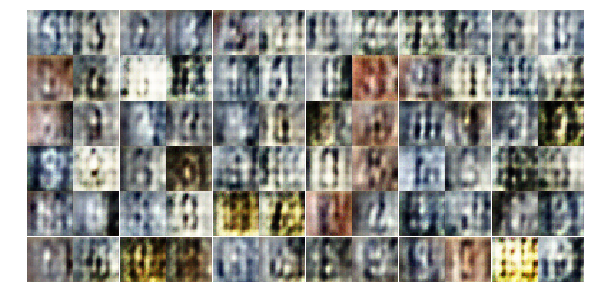

Epoch 2/25... Discriminator Loss: 0.8478... Generator Loss: 1.2975
Epoch 2/25... Discriminator Loss: 0.6619... Generator Loss: 1.4439
Epoch 2/25... Discriminator Loss: 0.4730... Generator Loss: 2.5442
Epoch 2/25... Discriminator Loss: 0.5859... Generator Loss: 1.4534
Epoch 2/25... Discriminator Loss: 0.8957... Generator Loss: 1.2977
Epoch 2/25... Discriminator Loss: 1.0881... Generator Loss: 0.7407
Epoch 2/25... Discriminator Loss: 1.2553... Generator Loss: 1.1012
Epoch 2/25... Discriminator Loss: 1.0630... Generator Loss: 0.7562
Epoch 2/25... Discriminator Loss: 0.7671... Generator Loss: 1.2927
Epoch 2/25... Discriminator Loss: 1.1381... Generator Loss: 0.6120


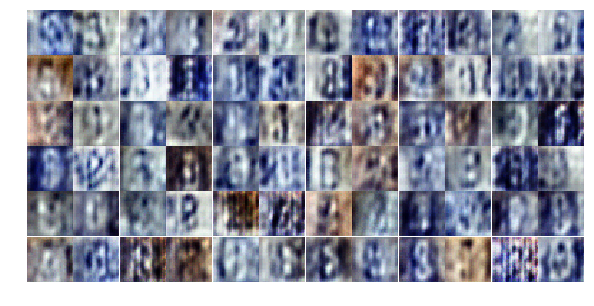

Epoch 2/25... Discriminator Loss: 0.9386... Generator Loss: 0.8044
Epoch 2/25... Discriminator Loss: 1.0428... Generator Loss: 0.9469
Epoch 2/25... Discriminator Loss: 0.8694... Generator Loss: 1.0037
Epoch 2/25... Discriminator Loss: 1.1403... Generator Loss: 0.8176
Epoch 2/25... Discriminator Loss: 1.1468... Generator Loss: 1.6015
Epoch 2/25... Discriminator Loss: 0.9322... Generator Loss: 1.1345
Epoch 2/25... Discriminator Loss: 0.9745... Generator Loss: 1.0459
Epoch 2/25... Discriminator Loss: 1.0057... Generator Loss: 0.9185
Epoch 2/25... Discriminator Loss: 1.2511... Generator Loss: 0.6802
Epoch 2/25... Discriminator Loss: 0.9938... Generator Loss: 1.0891


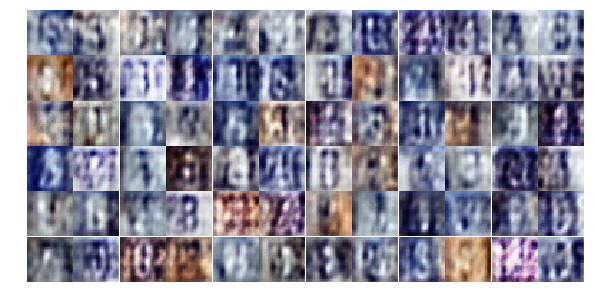

Epoch 2/25... Discriminator Loss: 0.9053... Generator Loss: 1.1176
Epoch 2/25... Discriminator Loss: 1.1449... Generator Loss: 1.2339
Epoch 2/25... Discriminator Loss: 1.2157... Generator Loss: 0.7978
Epoch 2/25... Discriminator Loss: 1.3477... Generator Loss: 0.6307
Epoch 2/25... Discriminator Loss: 0.9340... Generator Loss: 1.3670
Epoch 2/25... Discriminator Loss: 1.0575... Generator Loss: 1.0641
Epoch 2/25... Discriminator Loss: 1.0737... Generator Loss: 0.9661
Epoch 2/25... Discriminator Loss: 0.7867... Generator Loss: 1.9282
Epoch 2/25... Discriminator Loss: 0.9440... Generator Loss: 0.8707
Epoch 2/25... Discriminator Loss: 1.0388... Generator Loss: 0.9388


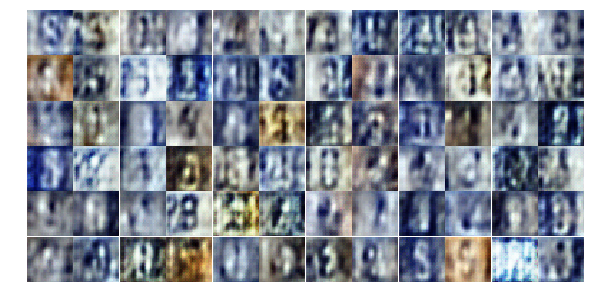

Epoch 2/25... Discriminator Loss: 0.7840... Generator Loss: 0.9839
Epoch 2/25... Discriminator Loss: 1.1376... Generator Loss: 0.8255
Epoch 2/25... Discriminator Loss: 0.8925... Generator Loss: 1.4855
Epoch 2/25... Discriminator Loss: 0.8266... Generator Loss: 1.3445
Epoch 2/25... Discriminator Loss: 0.9980... Generator Loss: 1.2512
Epoch 2/25... Discriminator Loss: 1.4293... Generator Loss: 0.4272
Epoch 2/25... Discriminator Loss: 1.3022... Generator Loss: 2.2487
Epoch 2/25... Discriminator Loss: 0.9969... Generator Loss: 0.7815
Epoch 2/25... Discriminator Loss: 0.5226... Generator Loss: 2.0852
Epoch 2/25... Discriminator Loss: 0.5802... Generator Loss: 1.4030


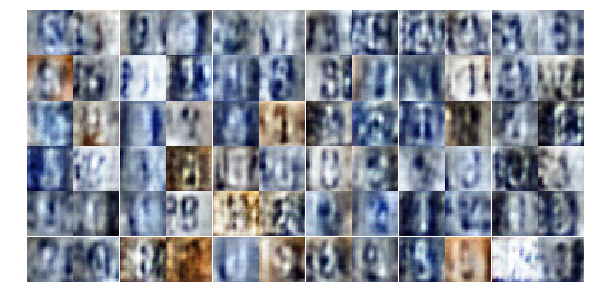

Epoch 2/25... Discriminator Loss: 0.5993... Generator Loss: 1.6093
Epoch 2/25... Discriminator Loss: 0.5443... Generator Loss: 2.0738
Epoch 2/25... Discriminator Loss: 1.5802... Generator Loss: 0.3778
Epoch 2/25... Discriminator Loss: 0.7861... Generator Loss: 0.9403
Epoch 3/25... Discriminator Loss: 0.7627... Generator Loss: 0.9627
Epoch 3/25... Discriminator Loss: 0.6380... Generator Loss: 1.0897
Epoch 3/25... Discriminator Loss: 0.7602... Generator Loss: 2.2031
Epoch 3/25... Discriminator Loss: 0.5313... Generator Loss: 1.5595
Epoch 3/25... Discriminator Loss: 1.1763... Generator Loss: 3.1185
Epoch 3/25... Discriminator Loss: 0.8454... Generator Loss: 1.0240


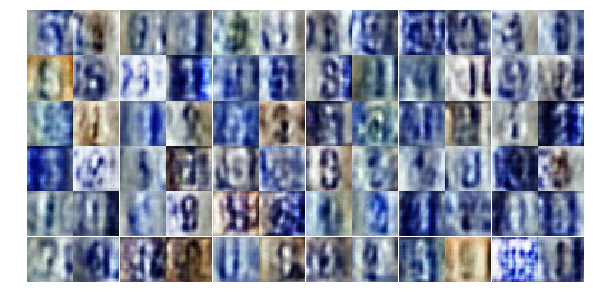

Epoch 3/25... Discriminator Loss: 0.6696... Generator Loss: 3.1560
Epoch 3/25... Discriminator Loss: 0.4819... Generator Loss: 1.4283
Epoch 3/25... Discriminator Loss: 0.5263... Generator Loss: 1.2910
Epoch 3/25... Discriminator Loss: 0.5867... Generator Loss: 1.5290
Epoch 3/25... Discriminator Loss: 1.3667... Generator Loss: 3.4395
Epoch 3/25... Discriminator Loss: 1.3238... Generator Loss: 0.5349
Epoch 3/25... Discriminator Loss: 0.3607... Generator Loss: 2.1813
Epoch 3/25... Discriminator Loss: 0.4769... Generator Loss: 1.7133
Epoch 3/25... Discriminator Loss: 0.4506... Generator Loss: 1.5459
Epoch 3/25... Discriminator Loss: 0.4917... Generator Loss: 1.4384


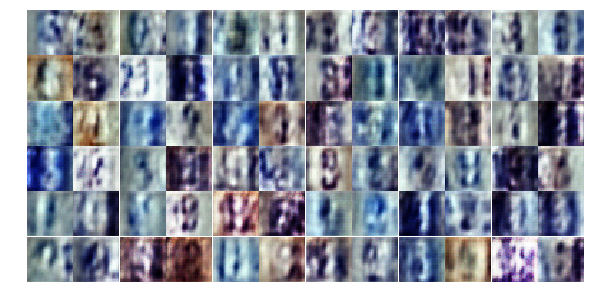

Epoch 3/25... Discriminator Loss: 0.7050... Generator Loss: 2.4398
Epoch 3/25... Discriminator Loss: 0.9412... Generator Loss: 2.1094
Epoch 3/25... Discriminator Loss: 0.3546... Generator Loss: 1.9930
Epoch 3/25... Discriminator Loss: 0.5931... Generator Loss: 3.7038
Epoch 3/25... Discriminator Loss: 0.6498... Generator Loss: 1.1133
Epoch 3/25... Discriminator Loss: 0.4714... Generator Loss: 1.9278
Epoch 3/25... Discriminator Loss: 0.7471... Generator Loss: 1.0487
Epoch 3/25... Discriminator Loss: 1.2260... Generator Loss: 2.9573
Epoch 3/25... Discriminator Loss: 0.4521... Generator Loss: 1.8276
Epoch 3/25... Discriminator Loss: 0.4072... Generator Loss: 1.8263


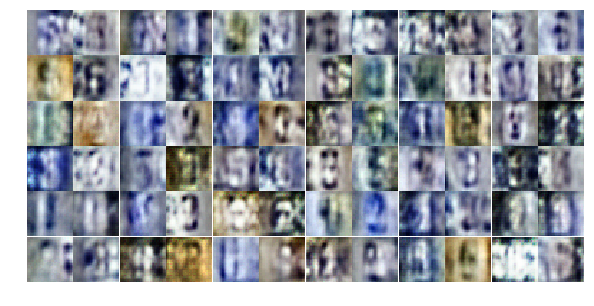

Epoch 3/25... Discriminator Loss: 0.4546... Generator Loss: 2.0875
Epoch 3/25... Discriminator Loss: 0.7647... Generator Loss: 0.9219
Epoch 3/25... Discriminator Loss: 1.0420... Generator Loss: 0.7265
Epoch 3/25... Discriminator Loss: 0.7827... Generator Loss: 0.9312
Epoch 3/25... Discriminator Loss: 0.3477... Generator Loss: 2.5255
Epoch 3/25... Discriminator Loss: 0.4954... Generator Loss: 1.8709
Epoch 3/25... Discriminator Loss: 0.6658... Generator Loss: 1.6092
Epoch 3/25... Discriminator Loss: 1.3313... Generator Loss: 0.4781
Epoch 3/25... Discriminator Loss: 0.8261... Generator Loss: 0.9607
Epoch 3/25... Discriminator Loss: 0.8217... Generator Loss: 1.0613


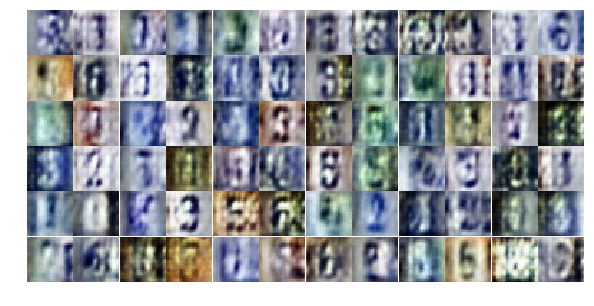

Epoch 3/25... Discriminator Loss: 0.5697... Generator Loss: 1.3600
Epoch 3/25... Discriminator Loss: 0.4165... Generator Loss: 1.7985
Epoch 3/25... Discriminator Loss: 0.3693... Generator Loss: 2.0757
Epoch 3/25... Discriminator Loss: 0.9482... Generator Loss: 0.9341
Epoch 3/25... Discriminator Loss: 0.3474... Generator Loss: 2.1782
Epoch 3/25... Discriminator Loss: 0.6478... Generator Loss: 1.8053
Epoch 3/25... Discriminator Loss: 0.3576... Generator Loss: 2.1547
Epoch 3/25... Discriminator Loss: 0.5290... Generator Loss: 1.5987
Epoch 3/25... Discriminator Loss: 0.6082... Generator Loss: 3.1297
Epoch 3/25... Discriminator Loss: 0.5662... Generator Loss: 2.2052


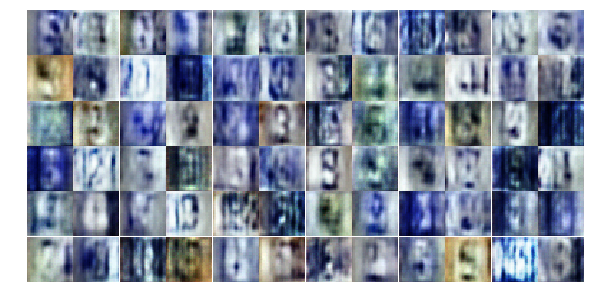

Epoch 3/25... Discriminator Loss: 2.0764... Generator Loss: 4.7265
Epoch 3/25... Discriminator Loss: 0.8979... Generator Loss: 1.2007
Epoch 3/25... Discriminator Loss: 0.8406... Generator Loss: 0.9665
Epoch 3/25... Discriminator Loss: 0.4141... Generator Loss: 1.9620
Epoch 3/25... Discriminator Loss: 0.4499... Generator Loss: 2.1421
Epoch 3/25... Discriminator Loss: 0.3203... Generator Loss: 2.2158
Epoch 3/25... Discriminator Loss: 0.4953... Generator Loss: 1.8165
Epoch 3/25... Discriminator Loss: 0.2723... Generator Loss: 3.0289
Epoch 3/25... Discriminator Loss: 0.3421... Generator Loss: 2.2122
Epoch 3/25... Discriminator Loss: 0.5013... Generator Loss: 1.4185


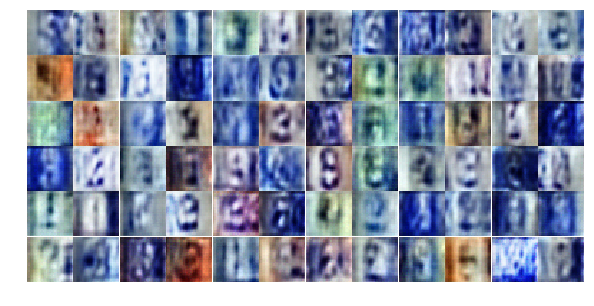

Epoch 3/25... Discriminator Loss: 0.9413... Generator Loss: 1.1495
Epoch 4/25... Discriminator Loss: 0.7593... Generator Loss: 1.0867
Epoch 4/25... Discriminator Loss: 1.0964... Generator Loss: 0.6323
Epoch 4/25... Discriminator Loss: 0.5632... Generator Loss: 2.2464
Epoch 4/25... Discriminator Loss: 0.4027... Generator Loss: 1.7156


KeyboardInterrupt: 

In [18]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

NameError: name 'losses' is not defined

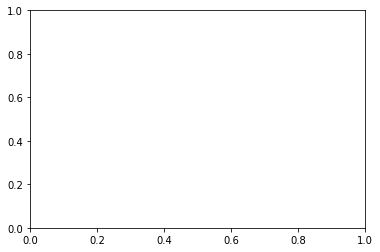

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))